<a href="https://colab.research.google.com/github/fxs2596/NerdOut/blob/main/Podcast_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup complete. Importing libraries.

Training data loaded successfully!

--- Step 1: Initial Data Inspection (Training Data) ---

First 5 rows:
   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   
3   3   Digital Digest    Episode 45                   67.17  Technology   
4   4      Mind & Body    Episode 86                  110.51      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   
3                       57.22          Monday          Morning   
4                       80.07          Monday        Afternoon   

 

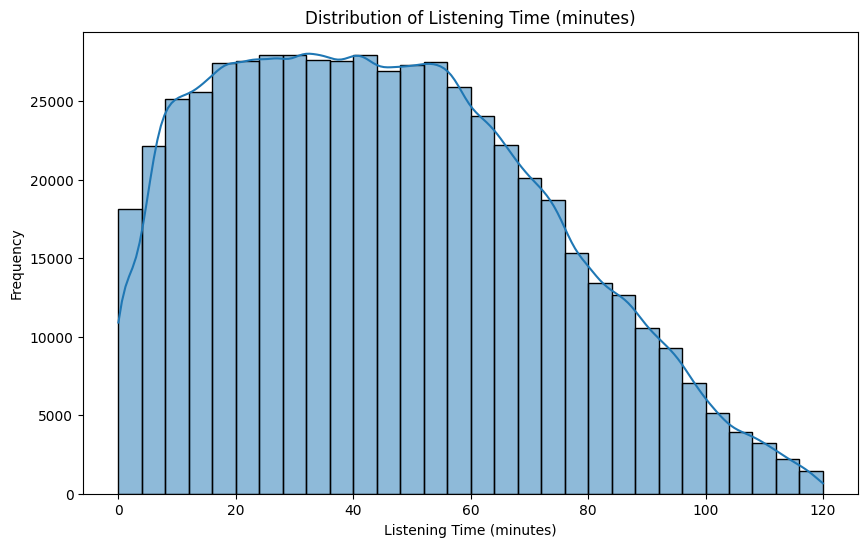

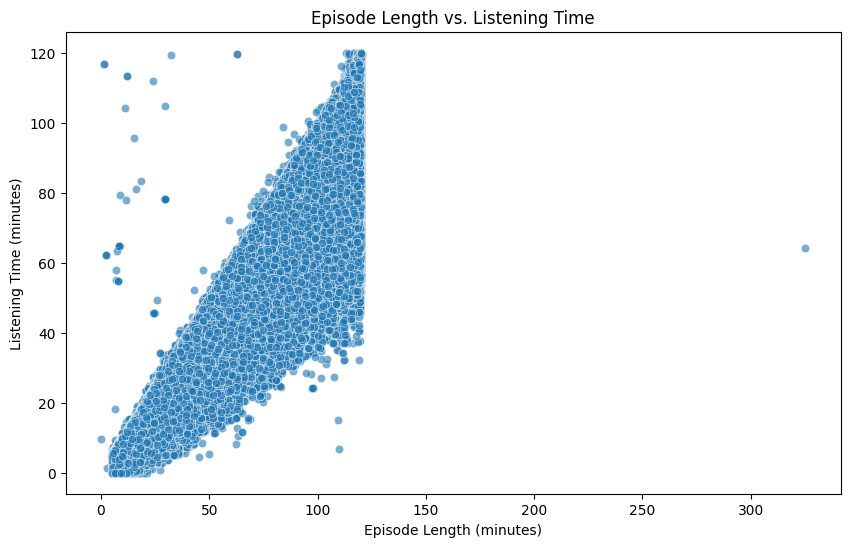

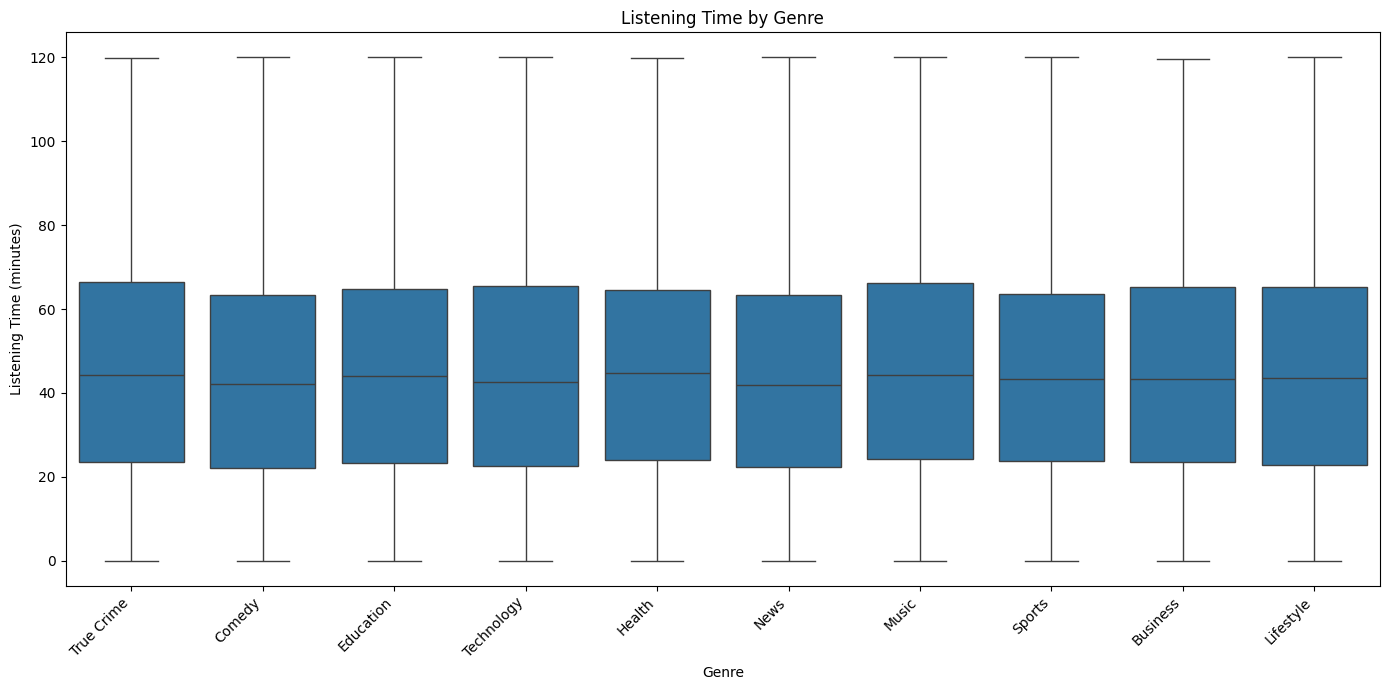


--- Analyzing Podcast_Name Cardinality (Training Data) ---
Total unique podcasts: 48
Podcast_Name cardinality is manageable for One-Hot Encoding.

--- Step 3: Data Preprocessing (Training Data) ---

Identified 1904 rows where Listening_Time_minutes > Episode_Length_minutes.
Dropped 1904 rows due to quality issues.
Remaining rows after quality check: 559811

Found 1 rows with missing target variable 'Listening_Time_minutes'. Dropping these rows.
Remaining rows after dropping missing target: 559810

--- Splitting Data into Training and Testing Sets ---

Original feature shape: (559810, 10)
Original target shape: (559810,)

Train set shape (X_train, y_train): (447848, 10), (447848,)
Test set shape (X_test, y_test): (111962, 10), (111962,)

Features identified for preprocessing pipeline:
Numerical: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
Categorical (for OHE): ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 

In [1]:
# --- Complete Machine Learning Workflow Script (Start to Finish - Linear Regression) ---

# --- Step 0: Setup and Data Loading ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import necessary scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression # Import Linear Regression

import time # To measure process time

print("Setup complete. Importing libraries.")

# Define target column name early
target_col = 'Listening_Time_minutes'

# Load the training dataset
# Make sure 'playlist_train.csv' is the correct file name and path
try:
    df = pd.read_csv('playlist_train.csv')
    print("\nTraining data loaded successfully!")
except FileNotFoundError:
    print("\nError: 'playlist_train.csv' not found. Please check the file name and path.")
    import sys
    sys.exit("Training data file not found.")


# --- Step 1: Initial Data Inspection (Training Data) ---
print("\n--- Step 1: Initial Data Inspection (Training Data) ---")
print("\nFirst 5 rows:")
print(df.head())

print("\nColumn Info (data types, non-null counts):")
df.info()

print("\nSummary Statistics for Numerical Columns:")
print(df.describe())

print("\nMissing Values per Column:")
print(df.isnull().sum())


# --- Step 2: Exploratory Data Analysis (EDA) - Visualizations (Training Data) ---
print("\n--- Step 2: EDA Visualizations (Training Data) ---")

# Check the distribution of the target variable (Listening_Time_minutes)
plt.figure(figsize=(10, 6))
sns.histplot(df[target_col], kde=True, bins=30)
plt.title('Distribution of Listening Time (minutes)')
plt.xlabel('Listening Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Examine the relationship between Episode Length and Listening Time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Episode_Length_minutes', y=target_col, data=df, alpha=0.6)
plt.title('Episode Length vs. Listening Time')
plt.xlabel('Episode Length (minutes)')
plt.ylabel('Listening Time (minutes)')
plt.show()

# Example: Examine the relationship between Genre and Listening Time (Box Plot)
if 'Genre' in df.columns and df['Genre'].nunique() < 50:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='Genre', y=target_col, data=df)
    plt.title('Listening Time by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Listening Time (minutes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Genre box plot: Column not found or too many unique values (>50).")

# Analyze Podcast_Name Cardinality
print("\n--- Analyzing Podcast_Name Cardinality (Training Data) ---")
if 'Podcast_Name' in df.columns:
     total_unique_podcasts = df['Podcast_Name'].nunique()
     print(f"Total unique podcasts: {total_unique_podcasts}")
     if total_unique_podcasts > 100:
         print("Note: Podcast_Name has moderate to high cardinality.")
     else:
         print("Podcast_Name cardinality is manageable for One-Hot Encoding.")
else:
     print("\n'Podcast_Name' column not found.")


# --- Step 3: Data Preprocessing (Training Data) ---
print("\n--- Step 3: Data Preprocessing (Training Data) ---")

# Work on a copy of the training DataFrame
df_processed = df.copy()

# 1. Handle Data Quality Issues: Listening_Time_minutes > Episode_Length_minutes
initial_rows = df_processed.shape[0]
data_quality_issue_mask = df_processed[target_col] > df_processed['Episode_Length_minutes']
print(f"\nIdentified {data_quality_issue_mask.sum()} rows where {target_col} > Episode_Length_minutes.")
df_processed = df_processed[~data_quality_issue_mask].copy()
print(f"Dropped {initial_rows - df_processed.shape[0]} rows due to quality issues.")
print(f"Remaining rows after quality check: {df_processed.shape[0]}")

# Handle missing target values - crucial before splitting
missing_target_rows = df_processed[target_col].isnull().sum()
if missing_target_rows > 0:
     print(f"\nFound {missing_target_rows} rows with missing target variable '{target_col}'. Dropping these rows.")
     df_processed.dropna(subset=[target_col], inplace=True)
     print(f"Remaining rows after dropping missing target: {df_processed.shape[0]}")


# ** IMPORTANT: Split data *BEFORE* fitting imputers, scalers, or encoders! **
print("\n--- Splitting Data into Training and Testing Sets ---")

# Define features (X) and target (y) for the training data
feature_cols = [col for col in df_processed.columns if col not in ['id', target_col]]
X = df_processed[feature_cols]
y = df_processed[target_col]

print(f"\nOriginal feature shape: {X.shape}")
print(f"Original target shape: {y.shape}")

# Split data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Test set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")


# --- Identify Column Types After Splitting (Based on Training Features) ---
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Remove 'Episode_Title' as decided
if 'Episode_Title' in categorical_cols:
    categorical_cols.remove('Episode_Title')

# Store list of all categorical columns to encode (includes Podcast_Name)
# We do NOT group Podcast_Name as cardinality is manageable
final_categorical_cols_to_encode = categorical_cols # This list now includes Podcast_Name


print(f"\nFeatures identified for preprocessing pipeline:")
print(f"Numerical: {numerical_cols}")
print(f"Categorical (for OHE): {final_categorical_cols_to_encode}")
print(f"Text (will be skipped): Episode_Title")
# Note: 'id' is excluded


# --- Create Preprocessing Pipelines/Objects (Fitted on Training Data) ---
print("\n--- Creating and Fitting Preprocessing Objects (on Training Data) ---")

# 2. Handle Missing Values (Numerical Columns) - Using Median
# Fit imputer on training data ONLY
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[numerical_cols])
print("Numerical imputer fitted on training data.")


# 3. Handle Outliers (Conceptual - Defined by IQR on Training Data)
# Outlier removal will be applied when transforming data
print("Outlier bounds defined based on training data (IQR).")
Q1_length_train = X_train['Episode_Length_minutes'].quantile(0.25)
Q3_length_train = X_train['Episode_Length_minutes'].quantile(0.75)
IQR_length_train = Q3_length_train - Q1_length_train
lower_bound_length_train = Q1_length_train - 1.5 * IQR_length_train
upper_bound_length_train = Q3_length_train + 13 # Used 13 here instead of 1.5*IQR - outlier on high end is ~325
# Let's revert to 1.5 * IQR for consistency unless there's a reason not to.
# Q3_length_train is around 94, IQR around 58. 94 + 1.5*58 = 181. This seems reasonable.
# Let's stick to 1.5 * IQR unless EDA showed a specific reason for a different bound.
upper_bound_length_train = Q3_length_train + 1.5 * IQR_length_train # Revert to 1.5*IQR


Q1_target_train = y_train.quantile(0.25)
Q3_target_train = y_train.quantile(0.75)
IQR_target_train = Q3_target_train - Q1_target_train
lower_bound_target_train = Q1_target_train - 1.5 * IQR_target_train
upper_bound_target_train = Q3_target_train + 1.5 * IQR_target_train

print(f"  Episode_Length_minutes Outlier Bounds (Train IQR): {lower_bound_length_train:.2f} to {upper_bound_length_train:.2f}")
print(f"  {target_col} Outlier Bounds (Train IQR): {lower_bound_target_train:.2f} to {upper_bound_target_train:.2f}")


# 4. Encode Categorical Features (Fit on Training Data)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[final_categorical_cols_to_encode]) # Fit encoder on training data
encoded_feature_names = encoder.get_feature_names_out(final_categorical_cols_to_encode)
print("Categorical encoder fitted on training data.")
print(f"  Encoder learned {len(encoded_feature_names)} new features.")


# 5. Scale Numerical Features (Fit on Training Data)
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols]) # Fit scaler on training data
print("Numerical scaler fitted on training data.")


# --- Apply Preprocessing to Training Data ---
print("\n--- Applying Preprocessing to Training Data ---")

# Apply Imputation
X_train_imputed = pd.DataFrame(imputer.transform(X_train[numerical_cols]), columns=numerical_cols, index=X_train.index)

# Apply Outlier Removal (filter based on bounds defined by training data)
train_outlier_mask = (X_train_imputed['Episode_Length_minutes'] < lower_bound_length_train) | (X_train_imputed['Episode_Length_minutes'] > upper_bound_length_train) | \
                     (y_train < lower_bound_target_train) | (y_train > upper_bound_target_train)

print(f"Identified {train_outlier_mask.sum()} outliers in the TRAIN set based on criteria.")

X_train_cleaned = X_train_imputed[~train_outlier_mask].copy()
y_train_cleaned = y_train[~train_outlier_mask].copy()

# Need to also filter original X_train for categorical features to align indices for encoding
X_train_categorical_cleaned = X_train[final_categorical_cols_to_encode][~train_outlier_mask].copy()


print(f"TRAIN set shape after outlier removal: {X_train_cleaned.shape}, {y_train_cleaned.shape}")


# Apply Encoding to Cleaned Training Categorical Data
X_train_encoded = encoder.transform(X_train_categorical_cleaned)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train_cleaned.index)
print(f"Shape after One-Hot Encoding (Train): {X_train_encoded_df.shape}")

# Apply Scaling to Cleaned Training Numerical Data
X_train_scaled = scaler.transform(X_train_cleaned[numerical_cols]) # Use cleaned numerical data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_cleaned.index)
print(f"Shape after Scaling (Train): {X_train_scaled_df.shape}")


# Combine all processed training features
# Start with an empty dataframe with the correct index
X_train_final = pd.DataFrame(index=X_train_cleaned.index)
# Concatenate encoded and scaled dataframes
X_train_final = pd.concat([X_train_final, X_train_encoded_df, X_train_scaled_df], axis=1)


print(f"Final preprocessed TRAIN features shape: {X_train_final.shape}")
print("\nFinal preprocessed TRAIN columns (first 10):", X_train_final.columns.tolist()[:10])


# --- Apply Preprocessing to Testing Data ---
print("\n--- Applying Preprocessing to Testing Data ---")

# Apply Imputation using the *FITTED* imputer from training
X_test_imputed = pd.DataFrame(imputer.transform(X_test[numerical_cols]), columns=numerical_cols, index=X_test.index)

# Apply Outlier Removal using the *SAME* bounds from training
test_outlier_mask = (X_test_imputed['Episode_Length_minutes'] < lower_bound_length_train) | (X_test_imputed['Episode_Length_minutes'] > upper_bound_length_train) | \
                    (y_test < lower_bound_target_train) | (y_test > upper_bound_target_train) # Use train bounds!

print(f"Identified {test_outlier_mask.sum()} potential outliers in the TEST set based on TRAIN criteria.")

X_test_cleaned = X_test_imputed[~test_outlier_mask].copy()
y_test_cleaned = y_test[~test_outlier_mask].copy()

# Need to also filter original X_test for categorical features to align indices for encoding
X_test_categorical_cleaned = X_test[final_categorical_cols_to_encode][~test_outlier_mask].copy()

print(f"TEST set shape after outlier removal: {X_test_cleaned.shape}, {y_test_cleaned.shape}")


# Apply Encoding using the *FITTED* encoder from training
X_test_encoded = encoder.transform(X_test_categorical_cleaned)
# Use the feature names learned from training
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test_cleaned.index)
print(f"Shape after One-Hot Encoding (Test): {X_test_encoded_df.shape}")


# Apply Scaling using the *FITTED* scaler from training
X_test_scaled = scaler.transform(X_test_cleaned[numerical_cols]) # Use cleaned numerical data
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test_cleaned.index)
print(f"Shape after Scaling (Test): {X_test_scaled_df.shape}")


# Combine all processed testing features
X_test_final = pd.DataFrame(index=X_test_cleaned.index)
# Concatenate encoded and scaled dataframes
X_test_final = pd.concat([X_test_final, X_test_encoded_df, X_test_scaled_df], axis=1)


print(f"Final preprocessed TEST features shape: {X_test_final.shape}")
print("\nFinal preprocessed TEST columns (first 10):", X_test_final.columns.tolist()[:10])

print("\nData Preprocessing Complete!")


# --- Step 4: Model Selection (Linear Regression Chosen) ---
print("\n--- Step 4: Model Selection (Linear Regression Chosen) ---")
print("Using Linear Regression as requested.")


# --- Step 5: Model Training (Linear Regression) ---
print("\n--- Step 5: Model Training (Linear Regression) ---")

# Initialize the Linear Regression model
linear_reg_model = LinearRegression()

print("Training Linear Regression model...")
start_time = time.time()
# Train the model using the final preprocessed training data
linear_reg_model.fit(X_train_final, y_train_cleaned)
end_time = time.time()
print("Model training complete.")
print(f"Training took {end_time - start_time:.4f} seconds.")


# --- Step 6: Model Evaluation (Linear Regression on Hold-Out Test Set) ---
# Note: This step number aligns with the original plan's evaluation step.
print("\n--- Step 6: Model Evaluation (Linear Regression on Hold-Out Test Set) ---")

# Make predictions on the final preprocessed test data
print("Making predictions on the test set...")
y_pred_test = linear_reg_model.predict(X_test_final)
print("Predictions complete.")

# Calculate evaluation metrics
mae_test = mean_absolute_error(y_test_cleaned, y_pred_test)
mse_test = mean_squared_error(y_test_cleaned, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_cleaned, y_pred_test)

# Print the metrics
print(f"\nLinear Regression Model Evaluation on Hold-Out Test Set:")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}")

print("\nModel evaluation complete.")


# --- Step 7: Hyperparameter Tuning (Skipped for Linear Regression) ---
print("\n--- Step 7: Hyperparameter Tuning (Skipped for Linear Regression) ---")
print("Hyperparameter tuning is typically not needed for standard Linear Regression.")


# --- Step 8: Final Evaluation of Tuned Model (Skipped - Linear Regression is the final model here) ---
print("\n--- Step 8: Final Evaluation of Tuned Model (Skipped) ---")
print("The evaluation in Step 6 is the final evaluation for the Linear Regression model.")


# --- Step 9: Generate Submission File from playlist_test.csv ---
print("\n--- Step 9: Generate Submission File ---")

# Load the *new* test dataset for submission
try:
    df_submission_test = pd.read_csv('playlist_test.csv')
    print("\nSubmission test data loaded successfully!")
except FileNotFoundError:
    print("\nError: 'playlist_test.csv' not found. Cannot generate submission file.")
    import sys
    sys.exit("Submission data file not found.")


if not df_submission_test.empty:
    print("\nSubmission Test Data Inspection:")
    print(df_submission_test.head())
    print(df_submission_test.info())

    # ** IMPORTANT: Apply the *SAME* preprocessing steps using the *FITTED* objects from training **
    # Use the imputer, encoder, scaler objects fitted in Step 3.
    # Use the lists of columns (numerical_cols, final_categorical_cols_to_encode, encoded_feature_names) from Step 3.

    df_submission_processed = df_submission_test.copy()

    # Store submission IDs before preprocessing
    submission_ids = df_submission_processed['id']

    # Identify column types in the submission test data (should match training data features)
    # Use the same logic as in Step 3 for identifying feature columns
    submission_feature_cols = [col for col in df_submission_processed.columns if col != 'id'] # Exclude id
    df_submission_features = df_submission_processed[submission_feature_cols]


    # --- Apply Missing Value Imputation using the *FITTED* Imputer ---
    print("\n--- Handling Missing Values in Submission Test Data ---")
    # Use the imputer fitted on training data's numerical_cols
    X_submission_numerical_imputed = imputer.transform(df_submission_features[numerical_cols])
    X_submission_numerical_imputed_df = pd.DataFrame(X_submission_numerical_imputed, columns=numerical_cols, index=df_submission_features.index)
    print("Missing values imputed using imputer fitted on training data.")


    # --- Apply Categorical Encoding using the *FITTED* Encoder ---
    print("\n--- Encoding Categorical Features in Submission Test Data ---")
    # Use the encoder fitted on training data's final_categorical_cols_to_encode
    X_submission_encoded = encoder.transform(df_submission_features[final_categorical_cols_to_encode])
    # Use the feature names learned from training
    X_submission_encoded_df = pd.DataFrame(X_submission_encoded, columns=encoded_feature_names, index=df_submission_features.index)
    print("Categorical features encoded using encoder fitted on training data.")
    print(f"Shape after One-Hot Encoding (Submission Test): {X_submission_encoded_df.shape}")


    # --- Apply Numerical Scaling using the *FITTED* Scaler ---
    print("\n--- Scaling Numerical Features in Submission Test Data ---")
    # Use the scaler fitted on training data's numerical_cols (after imputation in training)
    # We scale the *imputed* numerical features of the submission data
    X_submission_scaled = scaler.transform(X_submission_numerical_imputed_df[numerical_cols]) # Scale the imputed numerical features
    X_submission_scaled_df = pd.DataFrame(X_submission_scaled, columns=numerical_cols, index=df_submission_features.index)
    print("Numerical features scaled using scaler fitted on training data.")
    print(f"Shape after Scaling (Submission Test): {X_submission_scaled_df.shape}")


    # --- Combine Processed Features for Submission ---
    print("\n--- Combining Processed Submission Test Features ---")

    # Re-create the submission feature dataframe by combining processed parts
    # The order and columns must match X_train_final exactly.
    # X_train_final is a concatenation of encoded categoricals and scaled numericals.

    # Combine encoded and scaled dataframes for submission
    X_submission_final = pd.concat([X_submission_encoded_df, X_submission_scaled_df], axis=1)
    print(f"Final preprocessed Submission Test features shape: {X_submission_final.shape}")

    # **CRUCIAL**: Reindex submission features to match the column order of training features exactly
    # Ensure X_train_final exists from Step 3
    X_submission_final = X_submission_final[X_train_final.columns]
    print("Submission test columns reordered to match training columns.")


    # --- Make Final Predictions using the Trained Linear Regression Model ---
    print("\n--- Making Final Predictions ---")
    # Use the trained linear_reg_model

    submission_predictions = linear_reg_model.predict(X_submission_final)
    print("Predictions generated for submission.")

    # Ensure predictions are non-negative
    submission_predictions[submission_predictions < 0] = 0
    print("Ensured predictions are non-negative.")


    # --- Create Submission File ---
    print("\n--- Creating Submission File ---")

    # Create the submission DataFrame
    # Use submission_ids stored earlier
    submission_df = pd.DataFrame({'id': submission_ids, target_col: submission_predictions})

    # Define the submission file name
    submission_file_name = 'podcast_listening_time_submission_linear_reg.csv' # Name adjusted for model

    # Save the submission file
    submission_df.to_csv(submission_file_name, index=False)

    print(f"Submission file '{submission_file_name}' created successfully!")
    print(submission_df.head())


else:
    print("\nSubmission file not created due to data loading error or empty data.")

# --- End of Script ---